## Import Libraries

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import sys
sys.path.append('..')
from src.load import load_data
import pandas as pd
from src.ploter import Ploter
ploter = Ploter()

## Load Data

In [2]:
path_1 = '../Data/raw/Fraud_Data.csv'
path_2 = '../Data/raw/IpAddress_to_Country.csv'
fraud_df = load_data(path_1)
ip_df = load_data(path_2)
print(fraud_df.shape)
fraud_df.head()

(151112, 11)


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


## Data Cleaning

In [3]:
fraud_df.isnull().sum() # Checking missing values in fraud_df

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [4]:
ip_df.isnull().sum() # Checking Missing Values in ip_df

lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64

In [5]:
fraud_df.duplicated().sum() # Checking Duplicates in fraude_df

np.int64(0)

In [6]:
ip_df.duplicated().sum() # Checking Duplicates in ip_df

np.int64(0)

In [7]:
# Correct data types
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df.dtypes

user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address               float64
class                      int64
dtype: object

## Exploratory Data Analysis (EDA)

In [8]:
fraud_df['class'].value_counts(normalize=True)*100

class
0    90.635423
1     9.364577
Name: proportion, dtype: float64

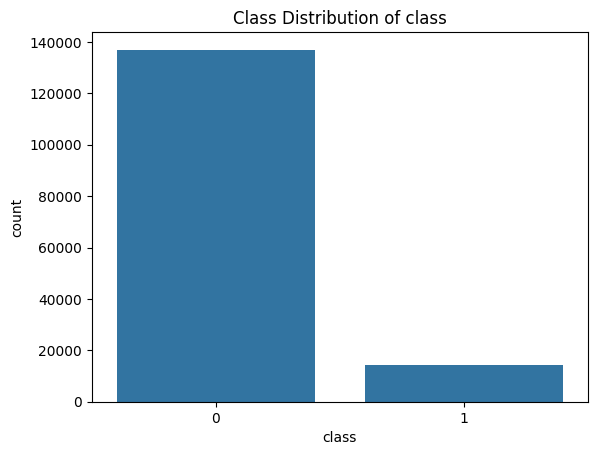

In [9]:
ploter.count_ploter('class', fraud_df) # class Distrbution

### Univariate Analysis

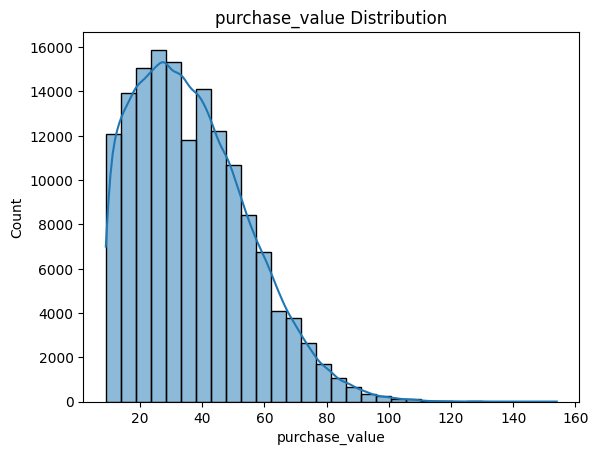

In [10]:
# Purchase Value Distribution
ploter.hist_ploter(fraud_df['purchase_value'])

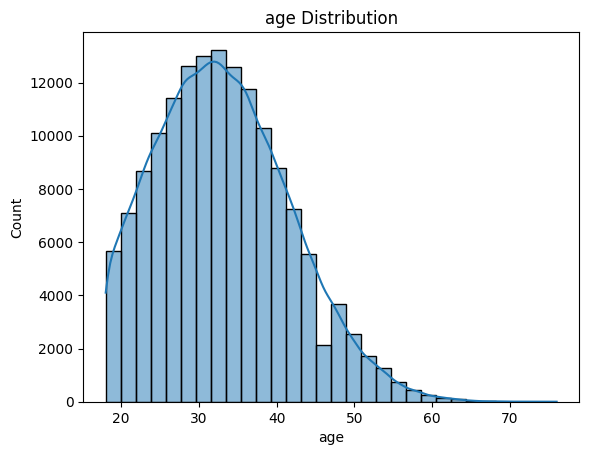

In [11]:
# Age Distribution
ploter.hist_ploter(fraud_df['age'])


### Bivariate Analysis

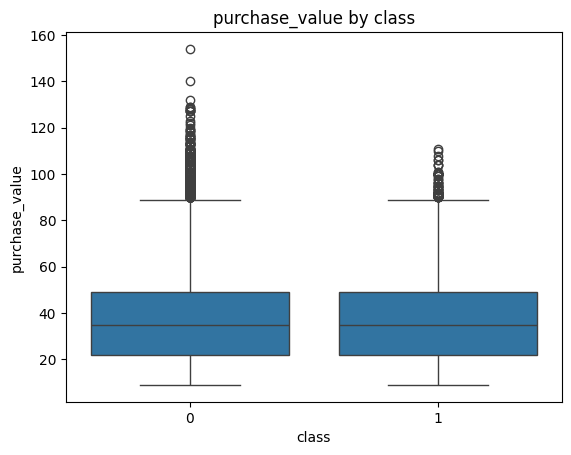

In [12]:
# Purchase Value vs Fraud
ploter.box_ploter('class', 'purchase_value', fraud_df)

## Geolocation Integration (IP → Country)

In [13]:
#Convert IP Address to Integer
fraud_df['ip_address'] = fraud_df['ip_address'].astype(int)
ip_df['lower_bound_ip_address'] = ip_df['lower_bound_ip_address'].astype(int)
ip_df['upper_bound_ip_address'] = ip_df['upper_bound_ip_address'].astype(int)


In [14]:
# Range-Based IP Merge
ip_df_sorted = ip_df.sort_values('lower_bound_ip_address')

fraud_df = pd.merge_asof(
    fraud_df.sort_values('ip_address'),
    ip_df_sorted,
    left_on='ip_address',
    right_on='lower_bound_ip_address',
    direction='backward'
)

fraud_df = fraud_df[
    fraud_df['ip_address'] <= fraud_df['upper_bound_ip_address']
]


In [15]:
# Fraud Analysis by Country
country_fraud = fraud_df.groupby('country')['class'].mean().sort_values(ascending=False)

country_fraud.head(10)


country
Turkmenistan             1.000000
Namibia                  0.434783
Sri Lanka                0.419355
Luxembourg               0.388889
Virgin Islands (U.S.)    0.333333
Ecuador                  0.264151
Tunisia                  0.262712
Peru                     0.260504
Bolivia                  0.245283
Kuwait                   0.233333
Name: class, dtype: float64

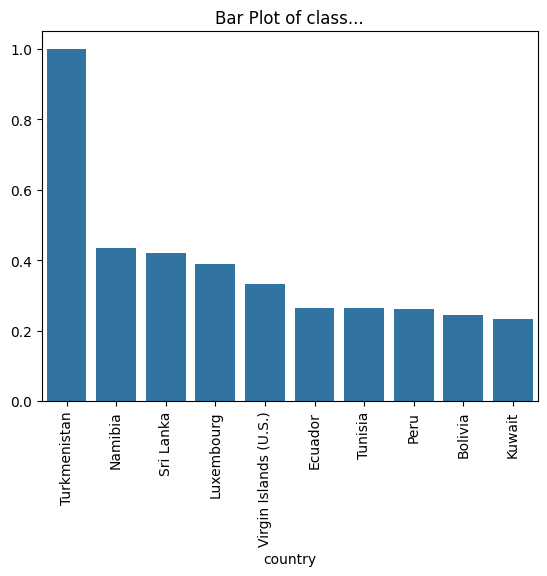

In [16]:
ploter.bar_ploter(country_fraud.head(10))

## Feature Engineering

In [17]:
# Time-Based Features
fraud_df['hour_of_purchase'] = fraud_df['purchase_time'].dt.hour
fraud_df['day_of_purchase'] = fraud_df['purchase_time'].dt.dayofweek


In [18]:
# Time Since Signup
fraud_df['time_since_signup'] = (fraud_df['purchase_time'] - fraud_df['signup_time']).dt.total_seconds()


In [19]:
# Transaction Frequency & Velocity
fraud_df['transaction_count'] = fraud_df.groupby('user_id')['purchase_time'].transform('count')


## Data Transformation

In [20]:
# Separate Features & Target
X = fraud_df.drop(columns=['class', 'signup_time', 'purchase_time', 'user_id', 'device_id', 'ip_address', 'lower_bound_ip_address', 'upper_bound_ip_address'])
y = fraud_df['class']


In [21]:
# Encode Categorical Variables
X = pd.get_dummies(X,columns=['browser', 'source', 'sex', 'country'],drop_first=True)


In [22]:
# Scale Numerical Features
scaler = StandardScaler()

num_cols = ['purchase_value', 'age', 'time_since_signup', 'transaction_count']
X[num_cols] = scaler.fit_transform(X[num_cols])

## Train-Test Split (Stratified)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)
y_train.value_counts(normalize=True) * 100


class
0    90.500987
1     9.499013
Name: proportion, dtype: float64

## Handle Class Imbalance (SMOTE – TRAIN ONLY)

In [24]:
smote = SMOTE(random_state=42)
x_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [25]:
# Class Distribution Before vs After
print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(y_train_res.value_counts())


Before SMOTE:
class
0    93502
1     9814
Name: count, dtype: int64

After SMOTE:
class
0    93502
1    93502
Name: count, dtype: int64


## Save data

In [27]:
x_train_res.to_csv('../Data/processed/x_train_resample.csv', index=False)
y_train_res.to_csv('../Data/processed/y_train_resample.csv', index=False)
X_test.to_csv('../Data/processed/X_test.csv', index=False)
y_test.to_csv('../Data/processed/y_test.csv', index=False)
